In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn
import os

import percolating_cluster
import monopole_data
import wrappings

pd.options.mode.chained_assignment = None

In [5]:
def fillup_copies(df):
    copy_num = df.groupby(['copy']).ngroups
    for i in range(1, copy_num + 1):
        df1 = df[df['copy'] == i - 1]
        df2 = df[df['copy'] == i]
        df3 = df1[~df1['conf'].isin(df2['conf'])]
        df3['copy'] = i
        df = pd.concat([df, df3])
    return df

def fill_funcational_max(df, groupby_keys):
    df2 = []
    copy_num = df.groupby(['copy']).ngroups
    for copy_max in range(1, copy_num + 1):
        df1 = df[df['copy'] <= copy_max]
        df1 = df1.groupby(groupby_keys + ['conf'])['functional'].max().reset_index(level=groupby_keys + ['conf'])
        df2.append(df1.groupby(groupby_keys)['functional']\
                   .agg([('functional', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=groupby_keys))
        df2[-1]['copy'] = copy_max
    return pd.concat(df2)

In [6]:
def read_functional(paths):
    df = []
    for path in paths:
        for i in range(path['conf_range'][0], path['conf_range'][1] + 1):
            data_path = path['path'] + f'_{i:04}'
            if(os.path.isfile(data_path)):
                df1 = pd.read_csv(data_path)
                if not df1.empty:
                    df.append(df1)
                    df[-1]['conf'] = i
                    if 'copy' in df[-1]:
                        if df[-1].loc[0, 'copy'] == 0:
                            df[-1]['copy'] = df[-1]['copy'] + 1
                    if 'parameters' in path:
                            for key, val in path['parameters'].items():
                                df[-1][key] = val
    return pd.concat(df)

In [7]:
def save_image(image_path, image_name, fg):
    try:
        os.makedirs(image_path)
    except:
        pass
    output_path = f'{image_path}/{image_name}'
    print(output_path)
    fg.savefig(output_path, dpi=800, facecolor='white')

# make plot
def make_plot(data, x, y, title, image_path, image_name, hue=None, err=None):
    fg = seaborn.FacetGrid(data=data, hue=hue, height=5,
                               aspect=1.61, legend_out=True)
    fg.figure.suptitle(title)
    if err == None:
        fg.map(plt.errorbar, x, y, mfc=None, fmt='o', ms=5, capsize=5, lw=0.5, ls=None
           ).add_legend()
    else:
        fg.map(plt.errorbar, x, y, err, mfc=None, fmt='o', ms=5, capsize=5, lw=0.5, ls=None
           ).add_legend()
    fg.ax.set_xlabel(x)
    fg.ax.set_ylabel(y)
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which='both', bottom=True,
                          top=True, left=True, right=True)
    plt.show()
    save_image(image_path, image_name, fg)

In [10]:
# average percolating cluster depending on gauge copy and on average functional
def percolating_cluster_copy(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, groupby_keys, hue, length_threshold, image_path, image_name):
    df_func = read_functional(paths_functional)
    df_func = fill_funcational_max(df_func, groupby_keys)
    df_clusters_wrapped = monopole_data.read_data_wrapped_copies(paths_clusters_wrapped)
    df_clusters_wrapped = df_clusters_wrapped.groupby(groupby_keys).apply(fillup_copies).reset_index(drop=True)
    df_clusters_unwrapped = monopole_data.read_data_unwrapped_copies(paths_clusters_unwrapped)
    df_clusters_unwrapped = df_clusters_unwrapped.groupby(groupby_keys).apply(fillup_copies).reset_index(drop=True)
    data_clusters = percolating_cluster.clusters_divide(df_clusters_unwrapped, df_clusters_wrapped, length_threshold, groupby_keys + ['conf', 'copy'])
    data_clusters = data_clusters.groupby(groupby_keys + ['copy'])['length'].agg([('length', np.mean), ('std_length', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=groupby_keys + ['copy'])
    data_clusters = data_clusters.merge(df_func, how='inner', on=groupby_keys + ['copy'])
    make_plot(data_clusters, 'functional', 'length', 'percolating cluster dependence on copy', image_path, image_name, hue=hue, err='std_length')

   color length x0_wrap x1_wrap x2_wrap x3_wrap percolating_group  conf  copy  \
0      1   2680       2       0      -1       1       percolating     1     1   
1      1   1878      -2      -1       0      -1       percolating     1     1   
2      1    524       0       1       1       0       percolating     1     1   
3      2   3172       0       1      -1      -1       percolating     1     1   
4      2   1400       0      -1       1       1       percolating     1     1   
..   ...    ...     ...     ...     ...     ...               ...   ...   ...   
4      1    112       0       0      -1       0       percolating   684     6   
5      2   3484       0      -1       1       0       percolating   684     6   
6      2    318       0       1      -1       0       percolating   684     6   
0      3      0       0       0       0       0       percolating   684     6   
0      3      0       0       0       0       0   non-percolating   684     6   

    steps  
0     100  
1  

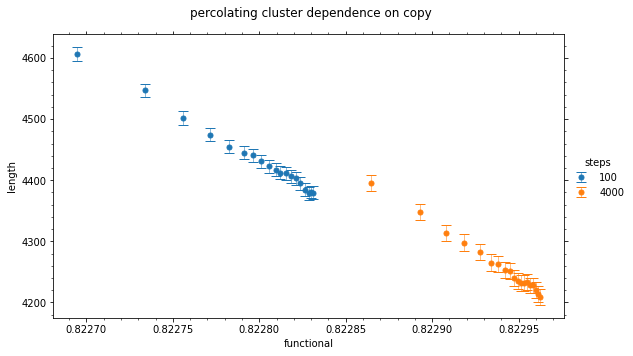

../../images/monopoles/su3/24^4/beta6.0/percolating_cluster_functional_dependence_beta6p0


In [11]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/functional', 'conf_range': (1, 1000), 'parameters': {'steps': 100}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_4000/copies=20/0.01/functional', 'conf_range': (1, 1000), 'parameters': {'steps': 4000}}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 100}, 'copies_num': 20},
                    {'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_4000/copies=20/0.01/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 4000}, 'copies_num': 20}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 100}, 'copies_num': 20},
                    {'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_4000/copies=20/0.01/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 4000}, 'copies_num': 20}]
percolating_cluster_copy(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['steps'], 'steps', 1500, '../../images/monopoles/su3/24^4/beta6.0', 'percolating_cluster_functional_dependence_beta6p0')

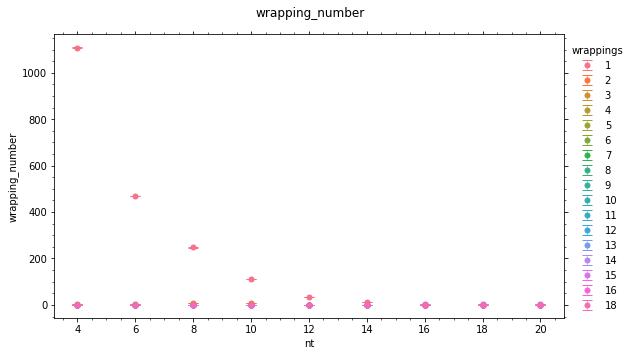

../../images/monopoles/su3/QCD/140MeV/wrappings_together


In [7]:
paths_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
df = wrappings.wrappings_separate(paths_wrapped, 1000000, ['nt'])
make_plot(df, 'nt', 'wrapping_number', 'wrapping_number', '../../images/monopoles/su3/QCD/140MeV', 'wrappings_together', hue='wrappings', err='std')

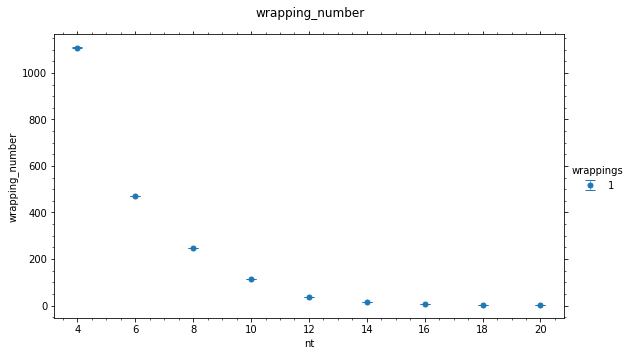

../../images/monopoles/su3/QCD/140MeV/wrappings_1


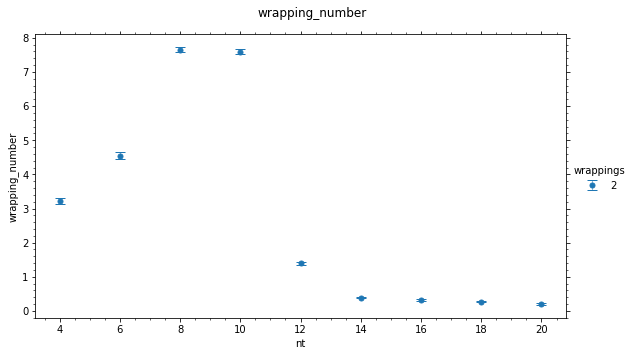

../../images/monopoles/su3/QCD/140MeV/wrappings_2


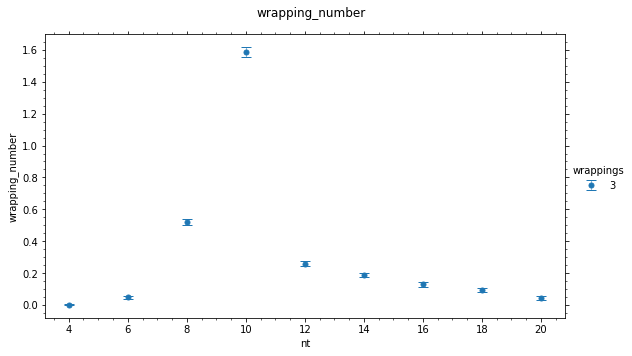

../../images/monopoles/su3/QCD/140MeV/wrappings_3


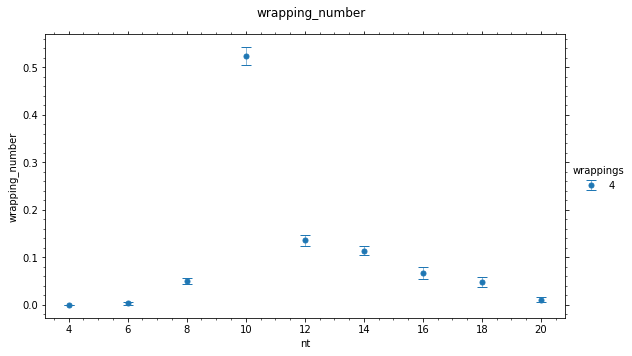

../../images/monopoles/su3/QCD/140MeV/wrappings_4


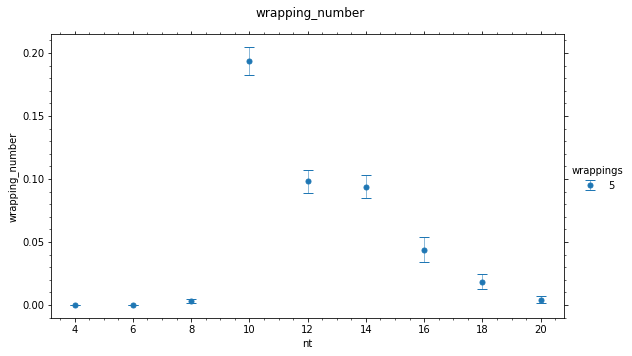

../../images/monopoles/su3/QCD/140MeV/wrappings_5


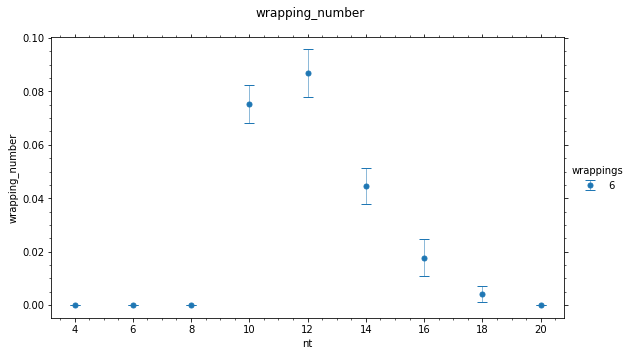

../../images/monopoles/su3/QCD/140MeV/wrappings_6


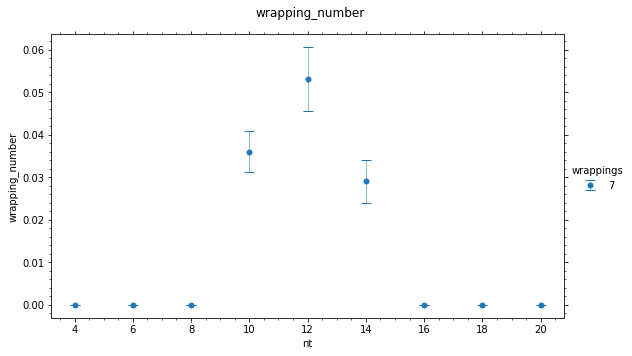

../../images/monopoles/su3/QCD/140MeV/wrappings_7


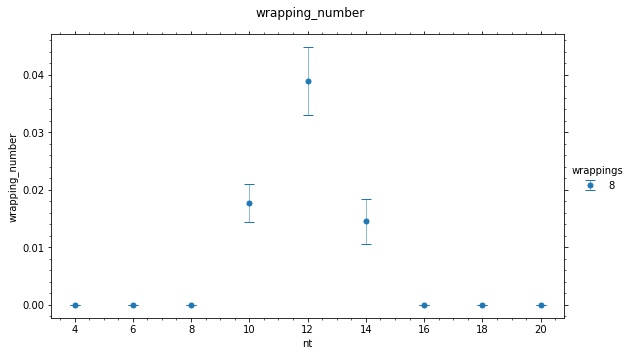

../../images/monopoles/su3/QCD/140MeV/wrappings_8


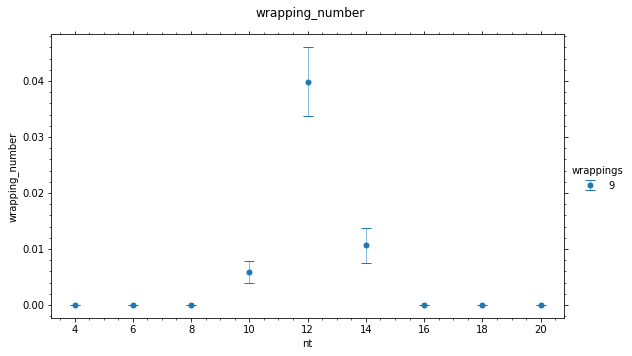

../../images/monopoles/su3/QCD/140MeV/wrappings_9


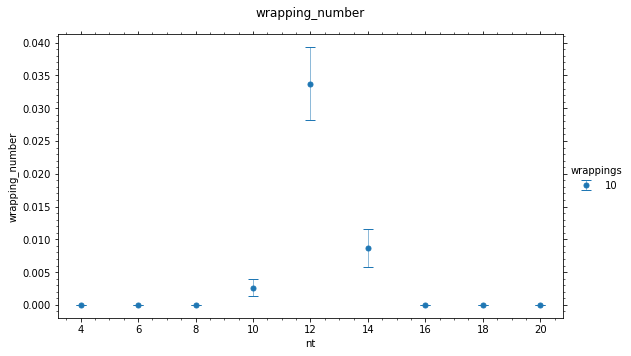

../../images/monopoles/su3/QCD/140MeV/wrappings_10


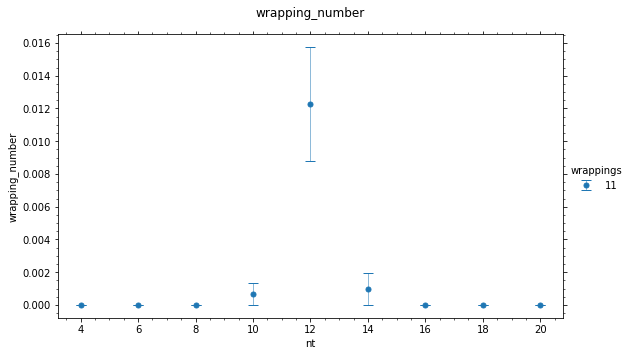

../../images/monopoles/su3/QCD/140MeV/wrappings_11


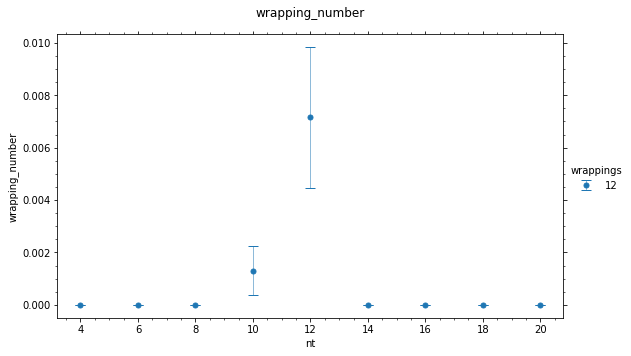

../../images/monopoles/su3/QCD/140MeV/wrappings_12


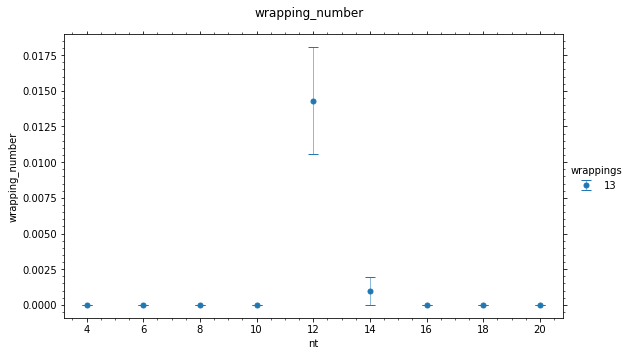

../../images/monopoles/su3/QCD/140MeV/wrappings_13


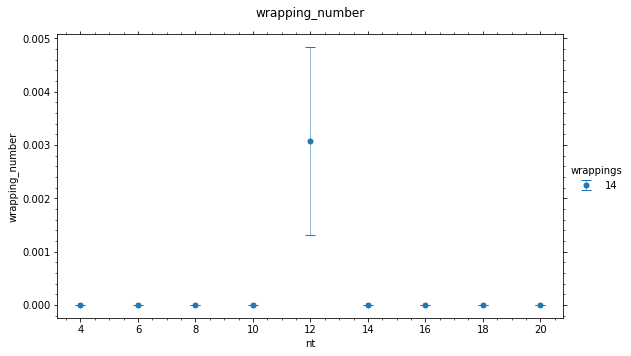

../../images/monopoles/su3/QCD/140MeV/wrappings_14


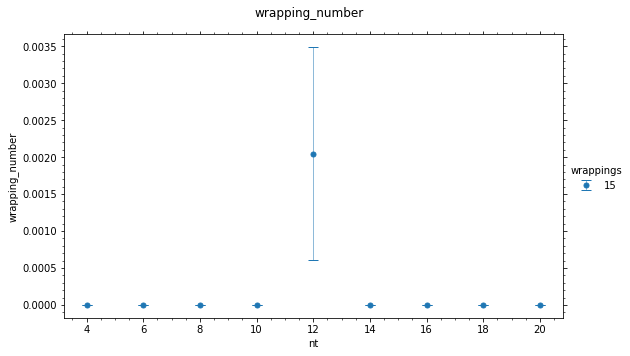

../../images/monopoles/su3/QCD/140MeV/wrappings_15


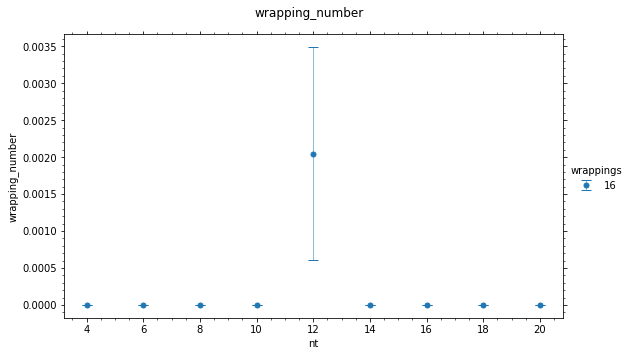

../../images/monopoles/su3/QCD/140MeV/wrappings_16


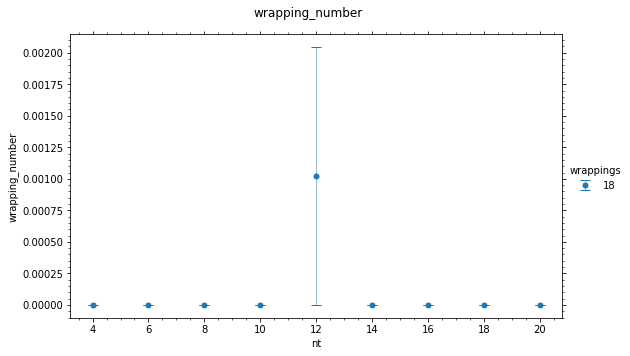

../../images/monopoles/su3/QCD/140MeV/wrappings_18


In [8]:
paths_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
df = wrappings.wrappings_separate(paths_wrapped, 1000000, ['nt'])
for wrap in df['wrappings'].unique():
    make_plot(df[df['wrappings'] == wrap], 'nt', 'wrapping_number', 'wrapping_number', '../../images/monopoles/su3/QCD/140MeV', f'wrappings_{wrap}', hue='wrappings', err='std')
# df.groupby('wrappings').apply(make_plot, 'nt', 'wrapping_number', 'wrapping_number', '../../images/monopoles/QCD/140MeV', 'wrappings', hue='wrappings', err='std')

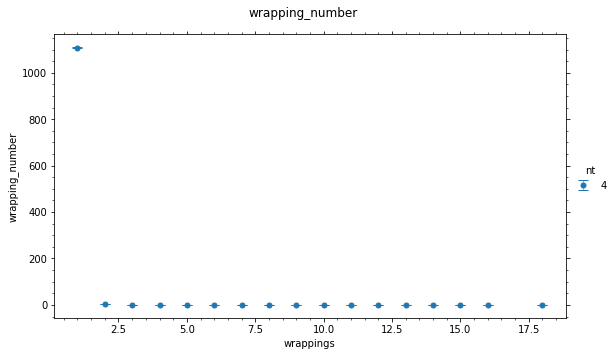

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=4


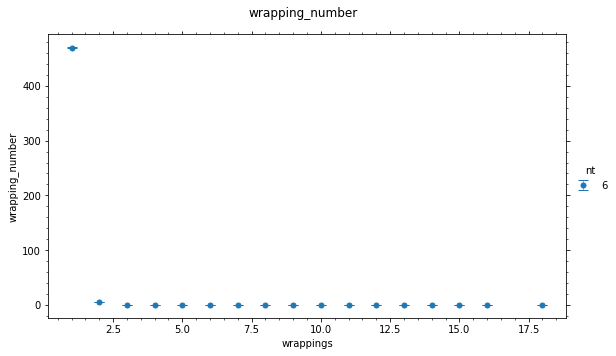

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=6


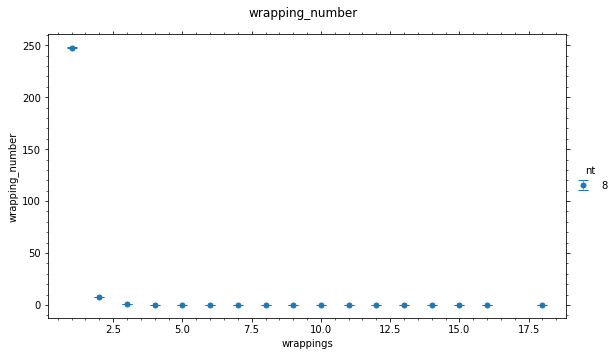

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=8


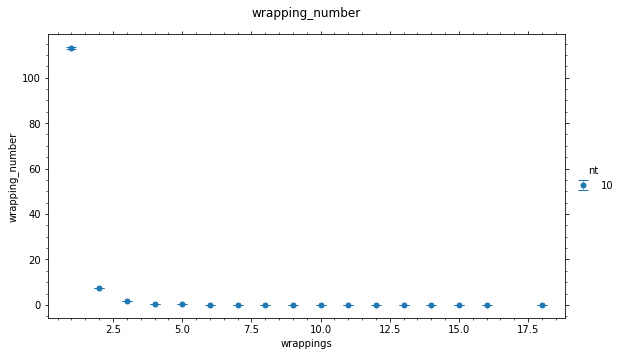

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=10


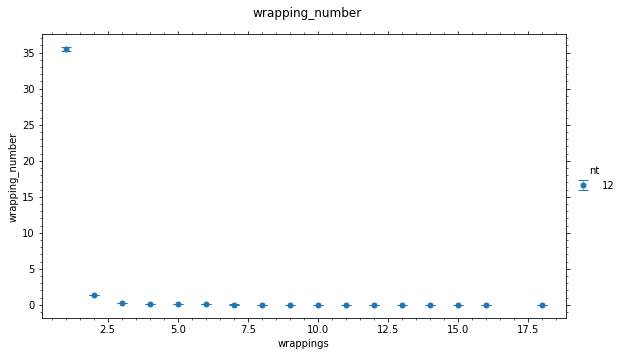

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=12


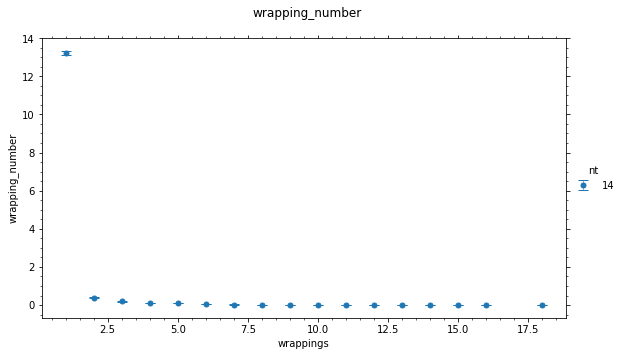

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=14


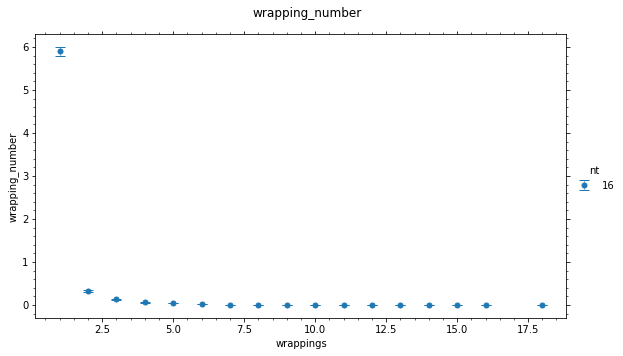

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=16


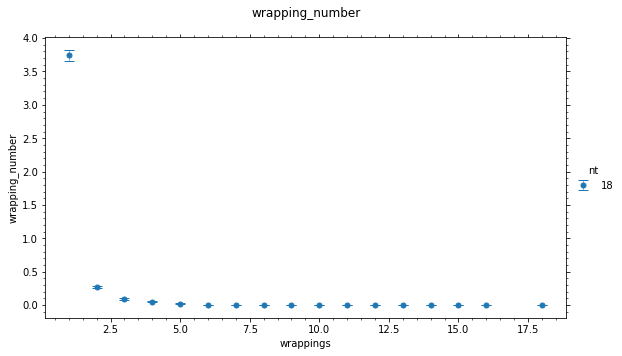

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=18


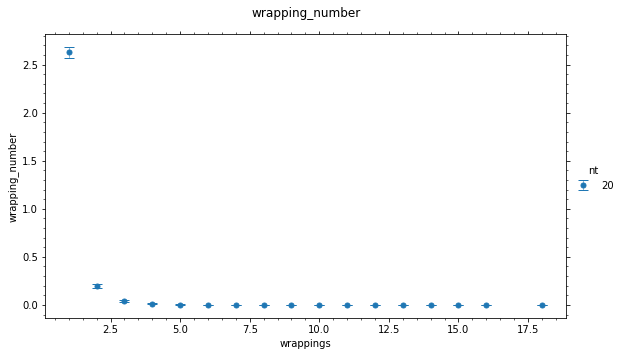

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=20


In [9]:
paths_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
df = wrappings.wrappings_separate(paths_wrapped, 1000000, ['nt'])
# make_plot(df, 'wrappings', 'wrapping_number', 'wrapping_number', '../../images/monopoles/QCD/140MeV', 'wrapping_nt', hue='nt', err='std')
for nt in df['nt'].unique():
    make_plot(df[df['nt'] == nt], 'wrappings', 'wrapping_number', 'wrapping_number', '../../images/monopoles/su3/QCD/140MeV', f'wrapping_number_nt={nt}', hue='nt', err='std')
# df.groupby('nt').apply(make_plot, 'wrappings', 'wrapping_number', 'wrapping_number', '../../images/monopoles/su3/QCD/140MeV', 'wrapping_number_nt', hue='nt', err='std')

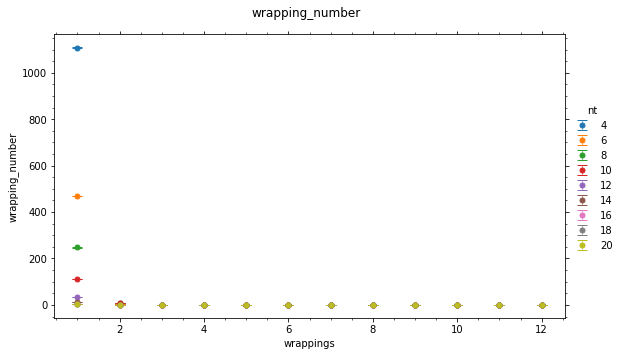

../../images/monopoles/su3/QCD/140MeV/wrappings_nt_together


In [10]:
paths_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
df = wrappings.wrappings_separate(paths_wrapped, 50000, ['nt'])
make_plot(df, 'wrappings', 'wrapping_number', 'wrapping_number', '../../images/monopoles/su3/QCD/140MeV', 'wrappings_nt_together', hue='nt', err='std')

In [11]:
def percolating_cluster_average(paths_wrapped, paths_unwrapped, groupby_keys, length_threshold, x, y, title, image_path, image_name, hue=None, err=None):
    df_clusters_wrapped = monopole_data.read_data_wrapped(paths_wrapped)
    df_clusters_unwrapped = monopole_data.read_data_unwrapped(paths_unwrapped)
    data_clusters = percolating_cluster.clusters_divide(df_clusters_unwrapped, df_clusters_wrapped, length_threshold, groupby_keys + ['conf'])
    print(data_clusters)
    data_clusters = data_clusters.groupby(groupby_keys)['length'].agg([('length', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=groupby_keys)
    print(data_clusters)
    make_plot(data_clusters, x, y, title, image_path, image_name, hue=hue)

      nt  conf         length
0      4   501     132.666667
1      4   502     105.333333
2      4   503     112.666667
3      4   504     116.666667
4      4   505     127.333333
...   ..   ...            ...
2540  20   694  161860.666667
2541  20   696  164998.666667
2542  20   697  161943.333333
2543  20   698  161780.000000
2544  20   699  163526.000000

[2545 rows x 3 columns]
   nt         length         std
0   4     117.119430    0.917482
1   6     334.550427    3.268953
2   8    1241.147256   10.338988
3  10    9437.643746  135.681859
4  12   66681.577982  308.126970
5  14   94752.381783  122.850770
6  16  128825.237500  194.167577
7  18  145410.879346  208.985641
8  20  164830.176955  267.196923


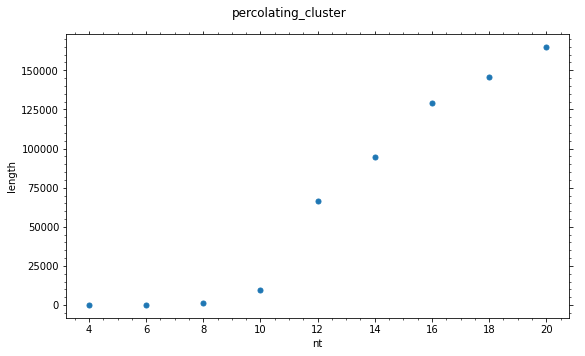

../../images/monopoles/su3/QCD/140MeV/percolating_cluster_nt


In [12]:
paths_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
paths_unwrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
percolating_cluster_average(paths_wrapped, paths_unwrapped, ['nt'], 10000, 'nt', 'length', 'percolating_cluster', '../../images/monopoles/su3/QCD/140MeV', 'percolating_cluster_nt', err='std')

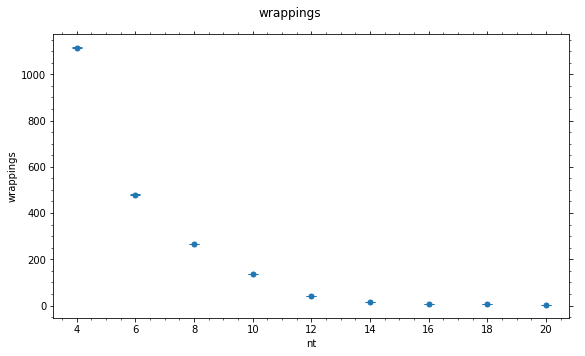

../../images/monopoles/su3/QCD/140MeV/wrappings_average


In [13]:
paths_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
df = wrappings.wrappings(paths_wrapped, 10000000, ['nt'])
make_plot(df, 'nt', 'wrappings', 'wrappings', '../../images/monopoles/su3/QCD/140MeV', 'wrappings_average', err='std')

In [14]:
def cluster_number_normalize(df):
    norm_factor = df.at[df['length'].idxmin(), 'number']
    df['number'] = df['number'] / norm_factor
    df['std'] = df['std'] / norm_factor
    return df

def cluster_number_aver(paths, length_threshold, groupby_keys, image_path, image_name, hue=None):
    df = monopole_data.read_data_unwrapped(paths)
    df = df[df['length'] < length_threshold]
    df = df.set_index(groupby_keys + ['color', 'conf', 'length']).unstack(['length'], fill_value=0).stack().reset_index()
    df = df.groupby(groupby_keys + ['length', 'conf'])['number'].agg([('number', np.mean)]).reset_index(level=groupby_keys + ['length'])
    df = df.groupby(groupby_keys + ['length'])['number'].agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=groupby_keys + ['length'])
    df = df.groupby(groupby_keys, group_keys=False).apply(cluster_number_normalize)
    make_plot(df, 'length', 'number', 'length distribution of non-percolating clusters', image_path, image_name, hue=hue, err='std')

def cluster_number_aver_copies(paths, length_threshold, groupby_keys, image_path, image_name, hue=None):
    df = monopole_data.read_data_unwrapped_copies(paths)
    df = df[df['length'] < length_threshold]
    df = df.set_index(groupby_keys + ['color', 'conf', 'length']).unstack(['length'], fill_value=0).stack().reset_index()
    df = df.groupby(groupby_keys + ['length', 'conf'])['number'].agg([('number', np.mean)]).reset_index(level=groupby_keys + ['length'])
    df = df.groupby(groupby_keys + ['length'])['number'].agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=groupby_keys + ['length'])
    # df = df.groupby(groupby_keys, group_keys=False).apply(cluster_number_normalize)
    make_plot(df, 'length', 'number', 'length distribution of non-percolating clusters', image_path, image_name, hue=hue, err='std')

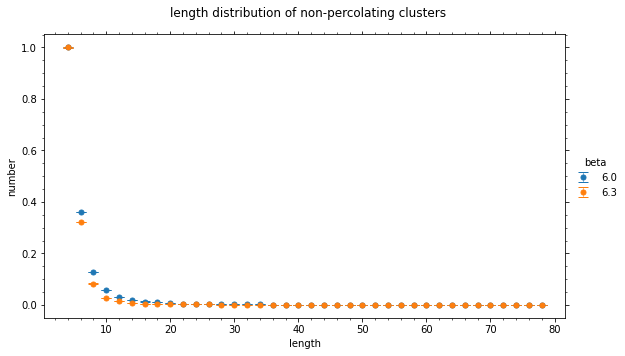

../../images/monopoles/su3/cluster_length_distribution_beta6p0_6p3


In [15]:
paths = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_500/copies=4/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0}},
         {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.3/steps_500/copies=4/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.3}}]
cluster_number_aver(paths, 80, ['beta'], '../../images/monopoles/su3', 'cluster_length_distribution_beta6p0_6p3', hue='beta')

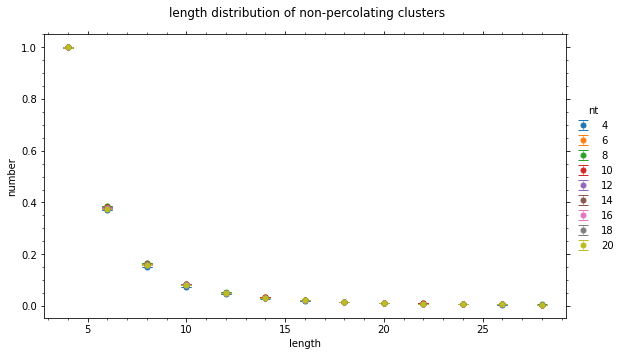

../../images/su3/QCD/140MeV/cluster_length_distribution_QCD_140MeV


In [16]:
paths = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
cluster_number_aver(paths, 30, ['nt'], '../../images/su3/QCD/140MeV', 'cluster_length_distribution_QCD_140MeV', hue='nt')

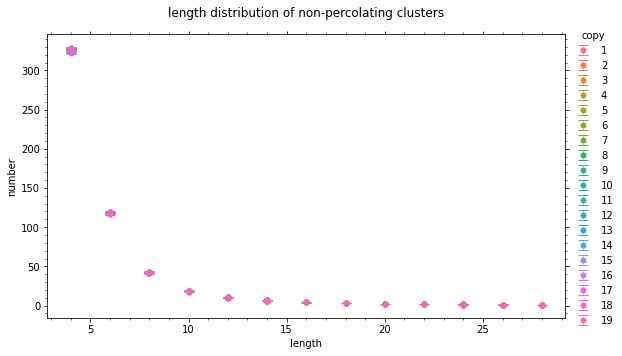

../../images/su3/gluodynamics/24^4/beta6.0/cluster_length_distribution_beta6p0


In [18]:
paths = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 100}, 'copies_num': 20}]
cluster_number_aver_copies(paths, 30, ['copy', 'steps'], '../../images/su3/gluodynamics/24^4/beta6.0', 'cluster_length_distribution_beta6p0', hue='copy')

In [19]:
# percolating cluster for each configuration depending on functional

def percolating_cluster_conf(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, copies_several, groupby_keys, length_threshold, x, y, title, image_path, image_name, hue=None, err=None):
    df_func = read_functional(paths_functional)
    if copies_several:
        df_clusters_wrapped = monopole_data.read_data_wrapped_copies(paths_clusters_wrapped)
        df_clusters_unwrapped = monopole_data.read_data_unwrapped_copies(paths_clusters_unwrapped)
    else:
        df_clusters_wrapped = monopole_data.read_data_wrapped(paths_clusters_wrapped)
        df_clusters_unwrapped = monopole_data.read_data_unwrapped(paths_clusters_unwrapped)
    data_clusters = percolating_cluster.clusters_divide(df_clusters_unwrapped, df_clusters_wrapped, length_threshold, groupby_keys)
    data_clusters = data_clusters.merge(df_func, how='inner', on=groupby_keys)
    make_plot(data_clusters, x, y, title, image_path, image_name, hue=hue, err=err)

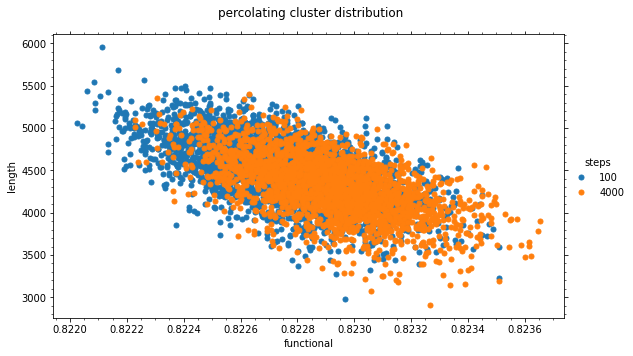

../../images/monopoles/su3/beta6.0/mag_dependence/percolating_cluster_mag_dependence_beta6p0_steps=100


In [20]:
params_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/functional', 'conf_range': (1, 1000), 'parameters': {'steps': 100}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_4000/copies=20/0.01/functional', 'conf_range': (1, 1000), 'parameters': {'steps': 4000}}]
params_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 100}, 'copies_num': 20},
                    {'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_4000/copies=20/0.01/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 4000}, 'copies_num': 20}]
params_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 100}, 'copies_num': 20},
                    {'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_4000/copies=20/0.01/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 4000}, 'copies_num': 20}]
percolating_cluster_conf(params_functional, params_clusters_wrapped, params_clusters_unwrapped, 'True', ['conf', 'copy', 'steps'], 1500, 'functional', 'length', 'percolating cluster distribution', '../../images/monopoles/su3/beta6.0/mag_dependence',
                        'percolating_cluster_mag_dependence_beta6p0_steps=100', hue='steps')

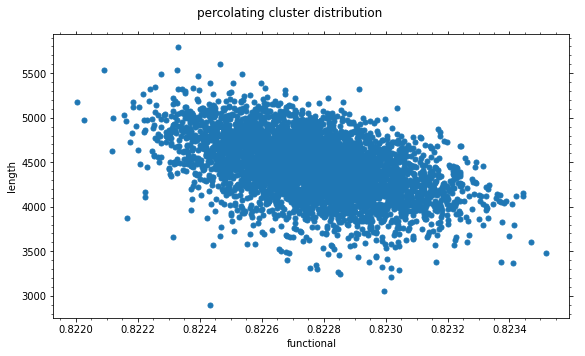

../../images/monopoles/su3/beta6.0/mag_dependence/percolating_cluster_mag_dependence_beta6p0_steps=500


In [21]:
params_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_500/copies=4/functional', 'conf_range': (1, 5000)}]
params_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_500/copies=4/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'copy': 4}}]
params_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_500/copies=4/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'copy': 4}}]
percolating_cluster_conf(params_functional, params_clusters_wrapped, params_clusters_unwrapped, False, ['conf', 'copy'], 1500, 'functional', 'length', 'percolating cluster distribution',
                         '../../images/monopoles/su3/beta6.0/mag_dependence', 'percolating_cluster_mag_dependence_beta6p0_steps=500')

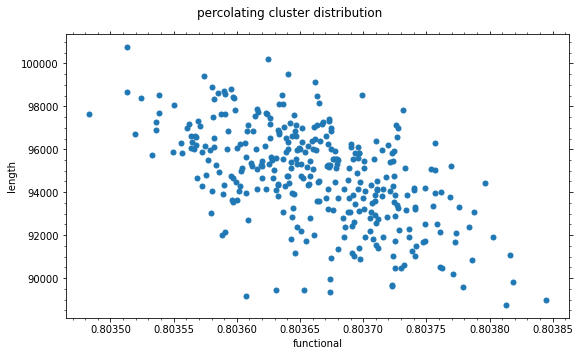

../../images/monopoles/su3/QCD/140MeV/nt14/mag_dependence/percolating_cluster_mag_dependence_nt14


In [22]:
params_functional = [{'path': '../../data/mag/functional/su3/QCD/140MeV/nt14/steps_2000/copies=1/functional', 'conf_range': [501, 860]}]
params_clusters_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [501, 860]}]
params_clusters_unwrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [501, 860]}]
percolating_cluster_conf(params_functional, params_clusters_wrapped, params_clusters_unwrapped, False, ['conf'], 50000, 'functional', 'length', 'percolating cluster distribution',
                         '../../images/monopoles/su3/QCD/140MeV/nt14/mag_dependence', 'percolating_cluster_mag_dependence_nt14')

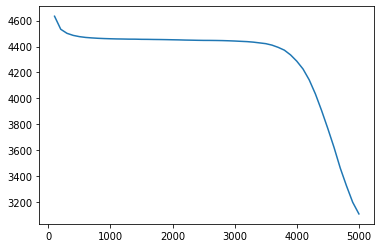

In [5]:
paths_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_500/copies=4/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000)}]
paths_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_500/copies=4/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000)}]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_500'

percolating_cluster.percolating_clusters(paths_unwrapped, paths_wrapped, 100, 5001, 100, ['conf'], image_path, image_name)